In [95]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import statsmodels.api as sm

import gc

%matplotlib inline

pd.set_option('display.max_columns', 50)

In [152]:
data = pd.read_csv('bank_marketing_train.csv')

y_map = {'no':0, 'yes':1}
data['y'] = data['y'].map(y_map)

# Data Info

In [3]:
print('data shape: {}'.format(data.shape))

data shape: (37068, 21)


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,37068.0,39.653286,9.461470,18.000,32.000,38.000,47.000,95.000
duration,37068.0,254.979012,259.979972,0.000,99.000,175.000,314.000,4918.000
campaign,37068.0,2.647189,2.876004,1.000,1.000,2.000,3.000,56.000
pdays,37068.0,989.565474,96.357433,0.000,999.000,999.000,999.000,999.000
previous,37068.0,0.100248,0.318217,0.000,0.000,0.000,0.000,4.000
emp.var.rate,37068.0,0.353075,1.387661,-2.900,-1.800,1.100,1.400,1.400
cons.price.idx,37068.0,93.613960,0.520734,92.469,93.075,93.918,93.994,94.465
cons.conf.idx,37068.0,-41.107484,3.996904,-50.000,-42.700,-42.000,-36.400,-33.600
euribor3m,37068.0,3.934684,1.536081,1.029,1.663,4.858,4.962,5.045
nr.employed,37068.0,5183.897782,52.929040,5076.000,5099.000,5196.000,5228.000,5228.000


Null値はない

In [5]:
data.isnull().any(axis=0)

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [6]:
cat_cols = data.select_dtypes('object').columns.tolist()
int_cols = data.select_dtypes(exclude='object').columns.tolist()
int_cols.remove('y')

In [7]:
print('category columns:', cat_cols)
print('numeric columns', int_cols)

category columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric columns ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


## ターゲットの比率

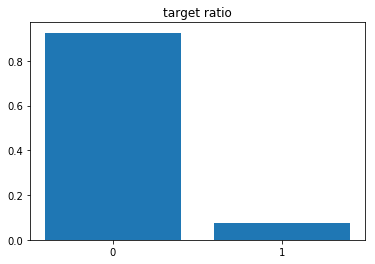

In [8]:
target_ratio = data['y'].value_counts() / len(data)

fig, ax = plt.subplots(1, 1)
ax.bar([0,1], target_ratio)
ax.set_xticks([0, 1])
ax.set_title('target ratio')
plt.show()

In [9]:
print('target ratio {:.4%}'.format(target_ratio[1]))

target ratio 7.4107%


imbalanceデータ

## Job 

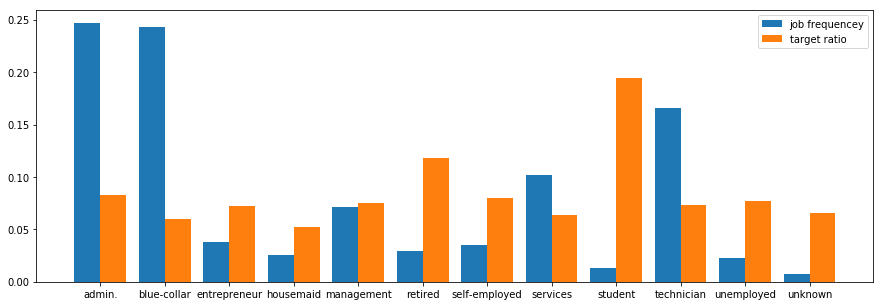

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

freq = data.groupby('job').size() / len(data)
target_ratio = data.groupby('job').y.mean()

wt = np.arange(len(freq.index))
ax.bar(wt, freq, width=0.4, label='frequencey')
ax.bar(wt +0.4 ,target_ratio , width=0.4, label='target ratio')
ax.set_xticks(wt + 0.2)
ax.set_xticklabels(freq.index)
plt.legend()
plt.show()

架電の傾向
- 主にadmin.(英語圏では総務的なポジションのことを指すらしい)とblue-coller、techicianといった技術職に架電が行われている
- グループ内のtargetの割合が高いのが引退したretiredと学生であるstudentが多い

仮説
- Studentのtagertの割合が高いのは年齢によるものではないか？

### Studentの年齢分布

In [11]:
student = data[data['job'] == 'student'].copy()

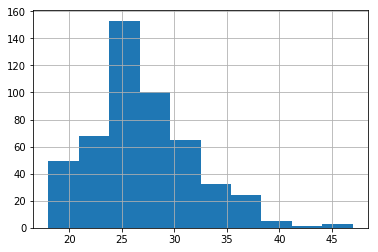

In [13]:
student['age'].hist();

25歳以下、26歳以上35歳以下、それ以上でビニングして各ビンのtagertの比率を比べる

In [15]:
def bining_age(age):
    if age <= 25:
        return 0
    elif 26 <= age < 35:
        return 1
    else:
        return 2

student['age_bin'] = student['age'].map(bining_age) 

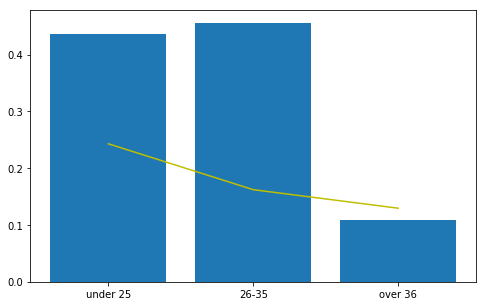

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
wt = np.arange(3)
bin_ratio = student.groupby('age_bin').size() / np.sum(student.groupby('age_bin').size())
target_ratio = student.groupby('age_bin').y.mean()
ax.bar(wt, bin_ratio, label='bin ratio')
ax.plot(target_ratio, c='y', label='target ratio')
ax.set_xticks(wt)
ax.set_xticklabels(['under 25', '26-35', 'over 36'])
plt.show()

仮説通りStudent内でも年齢が高くなるにつれてtagetの比率が下がることが分かった  


retiredのtarget比率が高い理由を探索する

### retiredの年齢分布

In [19]:
retired = data[data['job'] == 'retired'].copy()

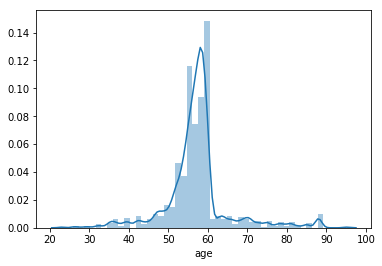

In [63]:
sns.distplot(retired['age']);

In [29]:
def bining_age(age):
    if age <= 49:
        return 0
    elif 50 <= age <  60:
        return 1
    elif 60 <= age < 70:
        return 2
    else:
        return 3

retired['age_bin'] = retired['age'].map(bining_age) 

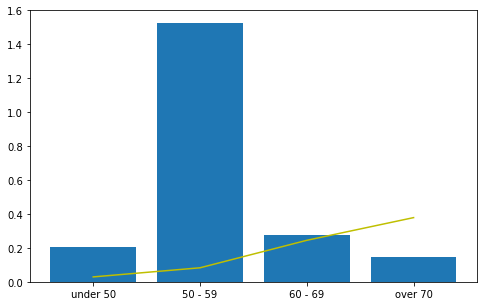

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
wt = np.arange(4)
bin_ratio = retired.groupby('age_bin').size() / np.sum(student.groupby('age_bin').size())
target_ratio = retired.groupby('age_bin').y.mean()
ax.bar(wt, bin_ratio, label='bin ratio')
ax.plot(target_ratio, c='y', label='target ratio')
ax.set_xticks(wt)
ax.set_xticklabels(['under 50', '50 - 59', '60 - 69', 'over 70'])
plt.show()

ある一定の年齢を超えるとtargetの割合が増えることがわかる

つまり年齢とターゲットのは2次関数的な下に凸な放物線のような形を描くのでは？

## 年齢分布

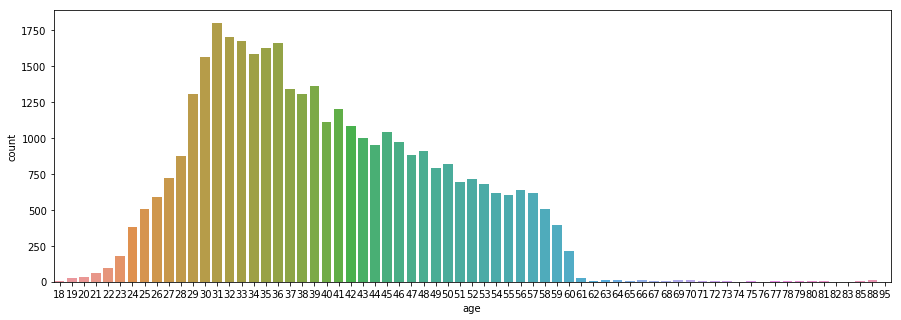

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(x='age', data=data, ax=ax)
plt.show()

In [48]:
def bining_age(age):
    if age <= 25:
        return '25 (under)'
    elif 26 <= age < 35:
        return '26 - 35'
    elif 35 < age <=  45:
        return '36 - 45'
    elif 45 < age <= 55:
        return '46 - 55'
    else:
        return  '56 (over)'

In [49]:
df_age = data[['age', 'y']].copy()

In [50]:
df_age['bin'] = data['age'].map(bining_age)

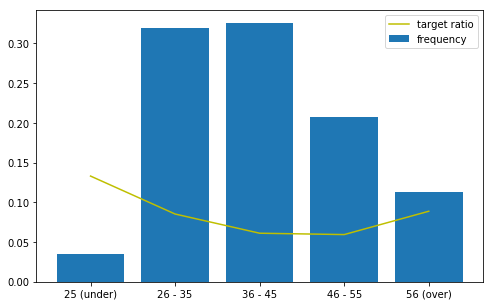

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
wt = np.arange(5)

freq = (df_age.groupby('bin').size() / len(data))
target_ratio = df_age.groupby('bin').y.mean()

ax.bar(wt, freq, label='frequency')
ax.plot(target_ratio, c='y', label='target ratio')
ax.set_xticks(wt)
ax.set_xticklabels(bin_ratio.index)
plt.legend()
plt.show()

In [66]:
data.groupby('job').age.mean()

job
admin.           38.200371
blue-collar      39.528484
entrepreneur     41.599281
housemaid        44.071125
management       42.147137
retired          57.240741
self-employed    40.119323
services         38.007930
student          26.864000
technician       38.444246
unemployed       39.678188
unknown          44.569444
Name: age, dtype: float64

以上より、target比率はjobよりはageによる影響が大きいと思われる。  
ここではこれ以上深掘りしないがofficeworkerの年齢の平均は30代後半から40代前半で一番targetの比率が底になるところになる  
突き詰めるなら各カテゴリ内で同様の年齢分布をとって、似たような傾向があるか探る。

## Education

In [70]:
def enc_education(education):
    if education in ['basic.4y', 'basic.6y', 'basic.9y']:
        #基礎教育
        return 'basic'
    elif education == 'high.school':
        #高等教育
        return 'higher'
    elif education in ['university.degree', 'professional.course']:
        #専門教育
        return 'university'
    else:
        return education

In [73]:
df_education = data[['education', 'y']].copy()

In [74]:
df_education['education'] = data['education'].map(enc_education)

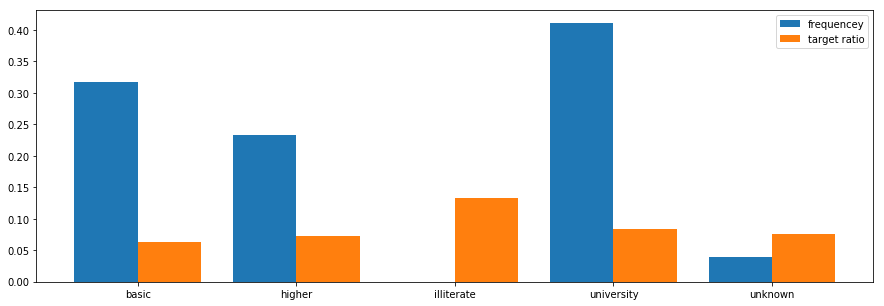

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

freq = df_education.groupby('education').size() / len(data)
target_ratio = df_education.groupby('education').y.mean()

wt = np.arange(len(freq))
ax.bar(wt, freq, width=0.4, label='frequencey')
ax.bar(wt +0.4 ,target_ratio , width=0.4, label='target ratio')
ax.set_xticks(wt + 0.2)
ax.set_xticklabels(freq.index)
plt.legend()
plt.show()

illiterate以外、学歴によるtargetの比率にはそれほど差は内容にない  

In [87]:
del df_education
gc.collect()

132146

## pdays

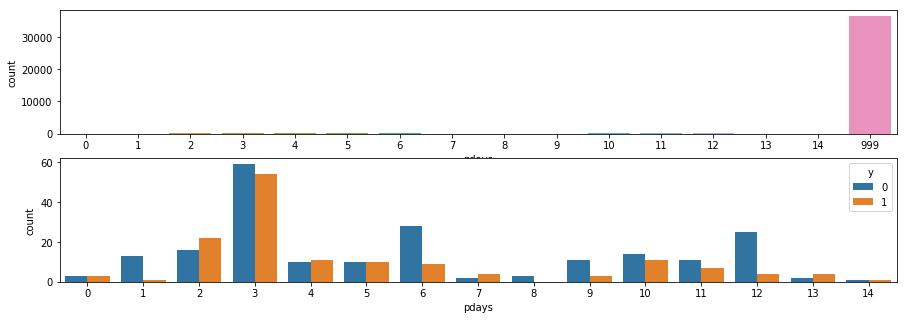

In [84]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes.ravel()
sns.countplot(x='pdays', data=data, ax=axes[0])
sns.countplot(x='pdays', hue='y', data=data[data['pdays'] != 999], ax=axes[1])
plt.show()

In [90]:
df_pdays = data[['pdays', 'y']].copy()

In [91]:
df_pdays['customer'] = data['pdays'].map(lambda x: 'newly' if x == 999 else 'exists')

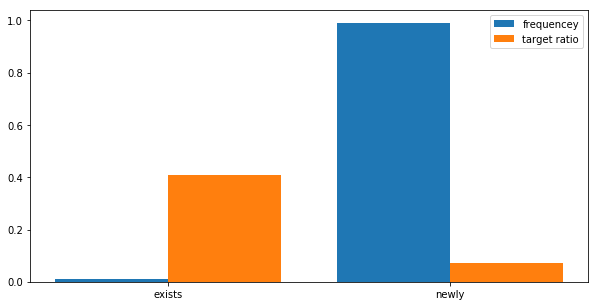

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

freq = df_pdays.groupby('customer').size() / len(data)
target_ratio = df_pdays.groupby('customer').y.mean()

wt = np.arange(len(freq.index))
ax.bar(wt, freq, width=0.4, label='frequencey')
ax.bar(wt +0.4 ,target_ratio , width=0.4, label='target ratio')
ax.set_xticks(wt + 0.2)
ax.set_xticklabels(freq.index)
plt.legend()
plt.show()

新規顧客より前回のキャンペーンで連絡が取れた顧客の方がtargetの比率が高い  
ただ顧客の新規開拓しないければならないのも事実なのでこれをどう受け止めるかは考えよう

## ロジスティック回帰で各変数の重要度をみる

- age:ビニング
- job:カテゴライズ
    - office worker、student、retired、その他
 - educatio：カテゴライズ
     - basicをまとめた基礎教育、high schoolの高等教育、それ以上の大学教育、illitarrate
- marital:カテゴライズ
    - 結婚しているパートナー持ち、離婚、未婚のシングル


カテゴリ変数はダミー変数化させて、基準のカテゴリを落とす

In [136]:
def bining_age(age):
    if age <= 25:
        return 'under 25'
    elif 26 <= age < 35:
        return '26 - 35'
    elif 35 < age <=  45:
        return '36 - 45'
    elif 45 < age <= 55:
        return '46 - 55'
    else:
        return  'over 56'
    
    
def enc_job(job):
    if job in ['admin.', 'blue-collar', 'management', 'entrepreneur']:
        #office worker
        return 'office worker'
    elif job in ['housemaid', 'services', 'technician', 'self-employed']:
        return 'other worker'
    else:
        return job
    
def enc_education(education):
    if education in ['basic.4y', 'basic.6y', 'basic.9y']:
        #基礎教育
        return 'basic'
    elif education == 'high.school':
        #高等教育
        return 'higher'
    elif education in ['university.degree', 'professional.course']:
        #専門教育
        return 'university'
    else:
        return education
    
def enc_marital(marital):
    if marital == 'married':
        #パートナーあり
        return 'has partner'
    elif marital in ['single', 'divorced']:
        #パートナーなし
        return 'single'
    else:
        return marital

def load_preprocess():
    bank_data = pd.read_csv('bank_marketing_train.csv')
    y_map = {'yes':1, 'no':0}
    bank_data['y'] = bank_data['y'].map(y_map)
    
    bank_data['age_bin'] = bank_data['age'].map(bining_age).astype(str)
    
    bank_data['default'] = bank_data['default'].str.replace('yes', 'unknown')
    bank_data['default'] = bank_data['default'].str.replace('unknown', 'yes_or_unkonwn')
    
    bank_data['pdays'] = bank_data['pdays'].map(lambda x: 'newly' if x == 999 else 'exisits').astype(str)
    
    bank_data['job_category'] = bank_data['job'].map(enc_job).astype(str)
    
    bank_data['education_category'] = bank_data['education'].map(enc_education).astype(str)
    
    bank_data['marital'] = bank_data['marital'].map(enc_marital)
      
    bank_data.drop(['job', 'education', 'duration', 'age'], axis=1, inplace=True)
    
    return bank_data

In [137]:
data = load_preprocess()

In [138]:
cat_cols = data.select_dtypes('object').columns
num_cols = data.select_dtypes(exclude='object').columns

dummy = pd.get_dummies(data[cat_cols], drop_first = True)
data = pd.concat([dummy, data[num_cols]], axis=1)

In [139]:
X = data.drop('y', axis=1)
y = data.y

In [140]:
glm = sm.GLM(y, X, family=sm.families.Binomial())
result = glm.fit()

In [141]:
df_sumarry = pd.DataFrame({'logit': np.exp(result.params), 'p-value':result.pvalues.values}, index=result.pvalues.index)

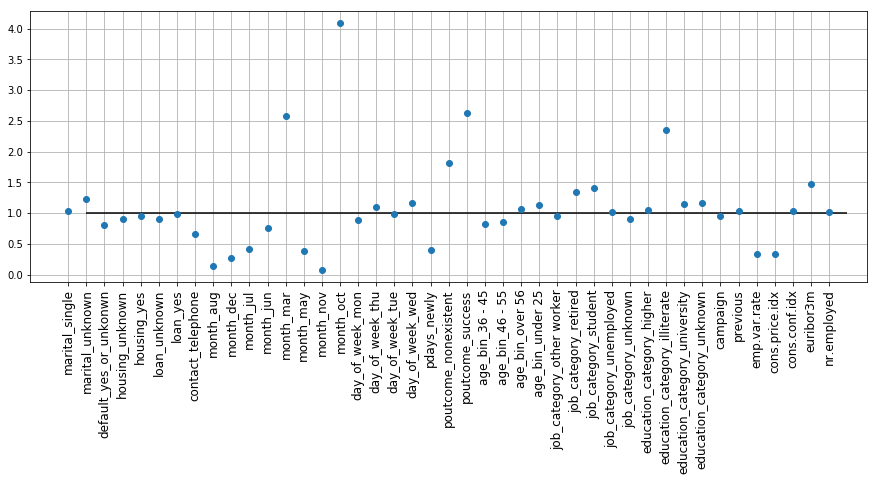

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.hlines(1, 1, len(df_sumarry.index))
ax.plot(df_sumarry.logit, 'o')
plt.xticks(range(df_sumarry.shape[0]), df_sumarry.index, rotation = 90, size=12)
ax.grid(True)

ビジネスで考えれば外的要因より、顧客自身がもつ性質で成約の期待値が高い顧客のペルソナを探した方がよさそう

In [143]:
data = load_preprocess()

In [144]:
data.drop(['month', 'nr.employed', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',  'day_of_week'], axis=1, inplace=True)

In [145]:
cat_cols = data.select_dtypes('object').columns
num_cols = data.select_dtypes(exclude='object').columns

dummy = pd.get_dummies(data[cat_cols], drop_first = True)
data = pd.concat([dummy, data[num_cols]], axis=1)

In [146]:
X = data.drop('y', axis=1)
y = data.y

In [147]:
glm = sm.GLM(y, X, family=sm.families.Binomial())
result = glm.fit()

In [148]:
df_sumarry = pd.DataFrame({'logit': np.exp(result.params), 'p-value':result.pvalues.values}, index=result.pvalues.index)

In [149]:
df_sumarry[df_sumarry['p-value'] <= 0.05]

,logit,p-value
default_yes_or_unkonwn,0.656715,6.619593e-13
contact_telephone,0.479797,6.296426e-51
pdays_newly,0.110490,1.126495e-31
age_bin_36 - 45,0.804658,2.983577e-05
age_bin_46 - 55,0.773083,2.843710e-05
age_bin_under 25,1.366681,1.184835e-03
job_category_other worker,0.908924,3.660004e-02
job_category_retired,1.686653,1.582798e-06
job_category_student,2.132798,4.359813e-09
education_category_university,1.160031,3.736008e-03


- deaultしていない方が成約率が高い
- contact telephoneよりcellerの方が成約率が高い
    - durationが起因?確かにcellularの方がduraionの平均は高いのだが、それほどの差ではない

### contact

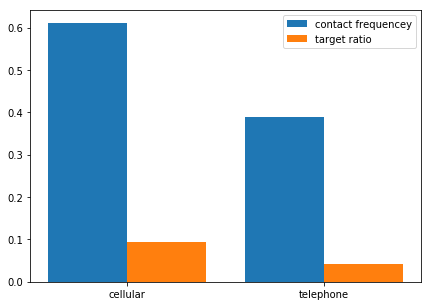

contact
cellular     258.654230
telephone    249.206727
Name: duration, dtype: float64


In [162]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ratio = data.groupby('contact').size() / len(data)
target_ratio = data.groupby('contact').y.mean()

wt = np.arange(len(ratio))
ax.bar(wt, ratio, width=0.4, label='contact frequencey')
ax.bar(wt +0.4 ,target_ratio , width=0.4, label='target ratio')
ax.set_xticks(wt + 0.2)
ax.set_xticklabels(ratio.index)

duraion_mean = data.groupby('contact').duration.mean()
# ax2= ax.twinx()
# ax2.plot(duraion_mean, c='r', label='duration mean sec')

plt.legend()
plt.show()

print(duraion_mean)

どんな顧客にアタックするべきか...

- 年齢は若い方がいい。それか55歳を超えたあたりの顧客。中年は成約率が低い
- 全くの新規の顧客より、前にコンタクトがとれた顧客は成約率が高い傾向にある
 - つまり中年の顧客でも以前コンタクトが取れた顧客であれば再アタックするのはいいかもしれない